# Get data

In [1]:
# get airbnb site to html like string
from urllib.request import urlopen
url = "http://insideairbnb.com/get-the-data"
page = urlopen(url)
html_bytes = page.read()
html = html_bytes.decode("utf-8")
html

'<!DOCTYPE html><html lang="en"><head><meta charSet="utf-8"/><meta http-equiv="x-ua-compatible" content="ie=edge"/><meta name="viewport" content="width=device-width, initial-scale=0.75, maximum-scale=0.75"/><meta name="generator" content="Gatsby 5.13.6"/><meta name="description" content="Adding data to the debate" data-gatsby-head="true"/><meta property="og:title" content="Get the Data" data-gatsby-head="true"/><meta property="og:description" content="Adding data to the debate" data-gatsby-head="true"/><meta property="og:type" content="website" data-gatsby-head="true"/><meta name="twitter:card" content="summary" data-gatsby-head="true"/><meta name="twitter:creator" content="@Murray" data-gatsby-head="true"/><meta name="twitter:title" content="Get the Data" data-gatsby-head="true"/><meta name="twitter:description" content="Adding data to the debate" data-gatsby-head="true"/><style data-href="/styles.db1591928cd0e0b93cdd.css" data-identity="gatsby-global-css">@charset "UTF-8";/*!\n * Boo

In [3]:
# get all urls from the site
import re
urls = re.findall(r'"http\S+"', html)

In [5]:
# filter data listings urls
urls_clean = [url.replace("\"","") for url in urls if 'data' in url and 'listings.csv.gz' in url]
urls_clean

['https://data.insideairbnb.com/united-states/ny/albany/2024-11-05/data/listings.csv.gz',
 'https://data.insideairbnb.com/the-netherlands/north-holland/amsterdam/2024-09-05/data/listings.csv.gz',
 'https://data.insideairbnb.com/belgium/vlg/antwerp/2024-09-26/data/listings.csv.gz',
 'https://data.insideairbnb.com/united-states/nc/asheville/2024-09-17/data/listings.csv.gz',
 'https://data.insideairbnb.com/greece/attica/athens/2024-09-23/data/listings.csv.gz',
 'https://data.insideairbnb.com/united-states/tx/austin/2024-09-13/data/listings.csv.gz',
 'https://data.insideairbnb.com/thailand/central-thailand/bangkok/2024-09-25/data/listings.csv.gz',
 'https://data.insideairbnb.com/spain/catalonia/barcelona/2024-09-06/data/listings.csv.gz',
 'https://data.insideairbnb.com/australia/sa/barossa-valley/2024-09-25/data/listings.csv.gz',
 'https://data.insideairbnb.com/australia/vic/barwon-south-west-vic/2024-09-25/data/listings.csv.gz',
 'https://data.insideairbnb.com/china/beijing/beijing/2023-1

In [7]:
# install wget, remove airbnb_data folder (if exists) and download data per city
!pip install wget
!rm -rf airbnb_data

import wget
import os
for url in urls_clean:
  url_split = url.split("/")
  if url_split[5] == 'data': continue
  city = url_split[3] if url_split[5] == 'data' else url_split[5] # link for malta is different
  out_dir = f"airbnb_data/{city}"
  os.makedirs(out_dir, exist_ok=False)
  print(f"{out_dir}/{url_split[-1]}")
  filename = wget.download(url, out=f"{out_dir}/{url_split[-1]}")

airbnb_data/albany/listings.csv.gz
100% [........................................................] 213329 / 213329airbnb_data/amsterdam/listings.csv.gz
100% [......................................................] 5751757 / 5751757airbnb_data/antwerp/listings.csv.gz
100% [......................................................] 1331629 / 1331629airbnb_data/asheville/listings.csv.gz
100% [......................................................] 1908544 / 1908544airbnb_data/athens/listings.csv.gz
100% [......................................................] 7901805 / 7901805airbnb_data/austin/listings.csv.gz
100% [......................................................] 8902975 / 8902975airbnb_data/bangkok/listings.csv.gz
100% [....................................................] 12630227 / 12630227airbnb_data/barcelona/listings.csv.gz
100% [......................................................] 9977937 / 9977937airbnb_data/barossa-valley/listings.csv.gz
100% [............................

In [9]:
# check size of each file
!du airbnb_data -h

2952	airbnb_data/zurich
4176	airbnb_data/thessaloniki
19496	airbnb_data/barcelona
99200	airbnb_data/paris
4224	airbnb_data/new-brunswick
368	airbnb_data/salem-or
19512	airbnb_data/broward-county
26104	airbnb_data/milan
12392	airbnb_data/santiago
17392	airbnb_data/austin
6008	airbnb_data/twin-cities-msa
28608	airbnb_data/melbourne
8	airbnb_data/beijing
1048	airbnb_data/rochester
8840	airbnb_data/valencia
1600	airbnb_data/newark
15128	airbnb_data/clark-county-nv
2456	airbnb_data/quebec-city
8	airbnb_data/shanghai
15296	airbnb_data/western-australia
2976	airbnb_data/columbus
2080	airbnb_data/fort-worth
46104	airbnb_data/puglia
18744	airbnb_data/mallorca
5816	airbnb_data/dublin
416	airbnb_data/barossa-valley
1176	airbnb_data/rotterdam
7864	airbnb_data/trentino
1264	airbnb_data/ghent
1408	airbnb_data/the-hague
3728	airbnb_data/asheville
4664	airbnb_data/victoria
1808	airbnb_data/jersey-city
8688	airbnb_data/seattle
1096	airbnb_data/cambridge
9848	airbnb_data/chicago
6608	airbnb_data/taipei


# Read data

In [12]:
# install pyspark and setup local spark session
!pip install pyspark -qq

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate() # “local” to run locally, [*] <- liczba rdzeni (np [1])

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/23 17:33:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/23 17:33:15 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [14]:
# import data from airbnb_data folder (each file ending with .gz)
listings_df = spark.read.option('multiLine', 'True')\
    .option('escape', '"').option("mode", "DROPMALFORMED")\
    .csv('airbnb_data/*/*.gz', header=True, inferSchema = True)

In [16]:
# check data schema
listings_df.printSchema()

root
 |-- id: long (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: long (nullable = true)
 |-- last_scraped: date (nullable = true)
 |-- source: string (nullable = true)
 |-- name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- picture_url: string (nullable = true)
 |-- host_id: integer (nullable = true)
 |-- host_url: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: date (nullable = true)
 |-- host_location: string (nullable = true)
 |-- host_about: string (nullable = true)
 |-- host_response_time: string (nullable = true)
 |-- host_response_rate: string (nullable = true)
 |-- host_acceptance_rate: string (nullable = true)
 |-- host_is_superhost: string (nullable = true)
 |-- host_thumbnail_url: string (nullable = true)
 |-- host_picture_url: string (nullable = true)
 |-- host_neighbourhood: string (nullable = true)
 |-- host_listings_count: int

In [18]:
# add column input_file and city from dir name
from pyspark.sql.functions import input_file_name, split, col
listings_df = listings_df\
    .withColumn("input_file", input_file_name())\
    .withColumn("city", split(col('input_file'), '/').getItem(5))

In [20]:
# print 10 first rows of dataset
listings_df.show(10)

25/01/23 17:33:49 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------+--------------------+--------------+------------+---------------+--------------------+--------------------+---------------------+--------------------+-------+--------------------+-----------------+----------+-------------+--------------------+------------------+------------------+--------------------+-----------------+--------------------+--------------------+--------------------+-------------------+-------------------------+--------------------+--------------------+----------------------+--------------------+----------------------+----------------------------+----------+---------+------------------+---------------+------------+---------+--------------+--------+----+--------------------+-------+--------------+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------+----------------+---------------+---------------+---------------+----------------+---------------------

In [22]:
listings_df

DataFrame[id: bigint, listing_url: string, scrape_id: bigint, last_scraped: date, source: string, name: string, description: string, neighborhood_overview: string, picture_url: string, host_id: int, host_url: string, host_name: string, host_since: date, host_location: string, host_about: string, host_response_time: string, host_response_rate: string, host_acceptance_rate: string, host_is_superhost: string, host_thumbnail_url: string, host_picture_url: string, host_neighbourhood: string, host_listings_count: int, host_total_listings_count: int, host_verifications: string, host_has_profile_pic: string, host_identity_verified: string, neighbourhood: string, neighbourhood_cleansed: string, neighbourhood_group_cleansed: string, latitude: double, longitude: double, property_type: string, room_type: string, accommodates: int, bathrooms: double, bathrooms_text: string, bedrooms: int, beds: int, amenities: string, price: string, minimum_nights: int, maximum_nights: int, minimum_minimum_nights: 

In [24]:
# we can work with data via sql lang
listings_df.createOrReplaceTempView('listings')
spark.sql('select distinct city from listings').show()
spark.sql('select * from listings where city = "london"').show(10)

+---------+
|     city|
+---------+
|Downloads|
+---------+



+---+-----------+---------+------------+------+----+-----------+---------------------+-----------+-------+--------+---------+----------+-------------+----------+------------------+------------------+--------------------+-----------------+------------------+----------------+------------------+-------------------+-------------------------+------------------+--------------------+----------------------+-------------+----------------------+----------------------------+--------+---------+-------------+---------+------------+---------+--------------+--------+----+---------+-----+--------------+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------+----------------+---------------+---------------+---------------+----------------+---------------------+-----------------+---------------------+----------------------+------------+-----------+--------------------+----------------------+

In [26]:
!rm -rf data.parquet
# we can write data as parquet
listings_df.write.parquet("data.parquet")

25/01/23 17:34:30 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
25/01/23 17:34:30 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
25/01/23 17:35:48 ERROR Utils: Aborting task                       (0 + 8) / 10]
java.lang.OutOfMemoryError: Java heap space
	at java.io.ByteArrayOutputStream.<init>(ByteArrayOutputStream.java:77)
	at org.apache.parquet.bytes.BytesInput$BAOS.<init>(BytesInput.java:257)
	at org.apache.parquet.bytes.BytesInput$BAOS.<init>(BytesInput.java:255)
	at org.apache.parquet.bytes.BytesInput.toByteArray(BytesInput.java:225)
	at org.apache.parquet.hadoop.ColumnChunkPageWriteStore$ColumnChunkPageWriter.writePage(ColumnChunkPageWriteStore.java:185)
	at org.apache.parquet.column.impl.ColumnWriterV1.writePage(ColumnWriterV1.java:59)
	at org.apache.parquet.column.impl.ColumnWriterBase.writePage(ColumnWr

Py4JJavaError: An error occurred while calling o52.parquet.
: org.apache.spark.SparkException: Job 9 cancelled because SparkContext was shut down
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1(DAGScheduler.scala:1253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1$adapted(DAGScheduler.scala:1251)
	at scala.collection.mutable.HashSet.foreach(HashSet.scala:79)
	at org.apache.spark.scheduler.DAGScheduler.cleanUpAfterSchedulerStop(DAGScheduler.scala:1251)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onStop(DAGScheduler.scala:3087)
	at org.apache.spark.util.EventLoop.stop(EventLoop.scala:84)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$stop$3(DAGScheduler.scala:2973)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1375)
	at org.apache.spark.scheduler.DAGScheduler.stop(DAGScheduler.scala:2973)
	at org.apache.spark.SparkContext.$anonfun$stop$12(SparkContext.scala:2258)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1375)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:2258)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:2211)
	at org.apache.spark.SparkContext.$anonfun$new$34(SparkContext.scala:681)
	at org.apache.spark.util.SparkShutdownHook.run(ShutdownHookManager.scala:214)
	at org.apache.spark.util.SparkShutdownHookManager.$anonfun$runAll$2(ShutdownHookManager.scala:188)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)
	at org.apache.spark.util.SparkShutdownHookManager.$anonfun$runAll$1(ShutdownHookManager.scala:188)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.util.SparkShutdownHookManager.runAll(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anon$2.run(ShutdownHookManager.scala:178)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$executeWrite$4(FileFormatWriter.scala:307)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.writeAndCommit(FileFormatWriter.scala:271)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeWrite(FileFormatWriter.scala:304)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:190)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:190)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:113)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:111)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:125)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:437)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:85)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:83)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:142)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:869)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:391)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:364)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:243)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:802)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)


In [28]:
!du -h data.parquet

  0B	data.parquet


In [30]:
# and read it easily
parDF1=spark.read.parquet("data.parquet")

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/socket.py", line 708, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 54] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


Py4JError: An error occurred while calling o24.read

In [32]:
parDF1.printSchema()

NameError: name 'parDF1' is not defined

In [17]:
import pandas as pd
a = pd.read_parquet('data.parquet')

<Axes: ylabel='city'>

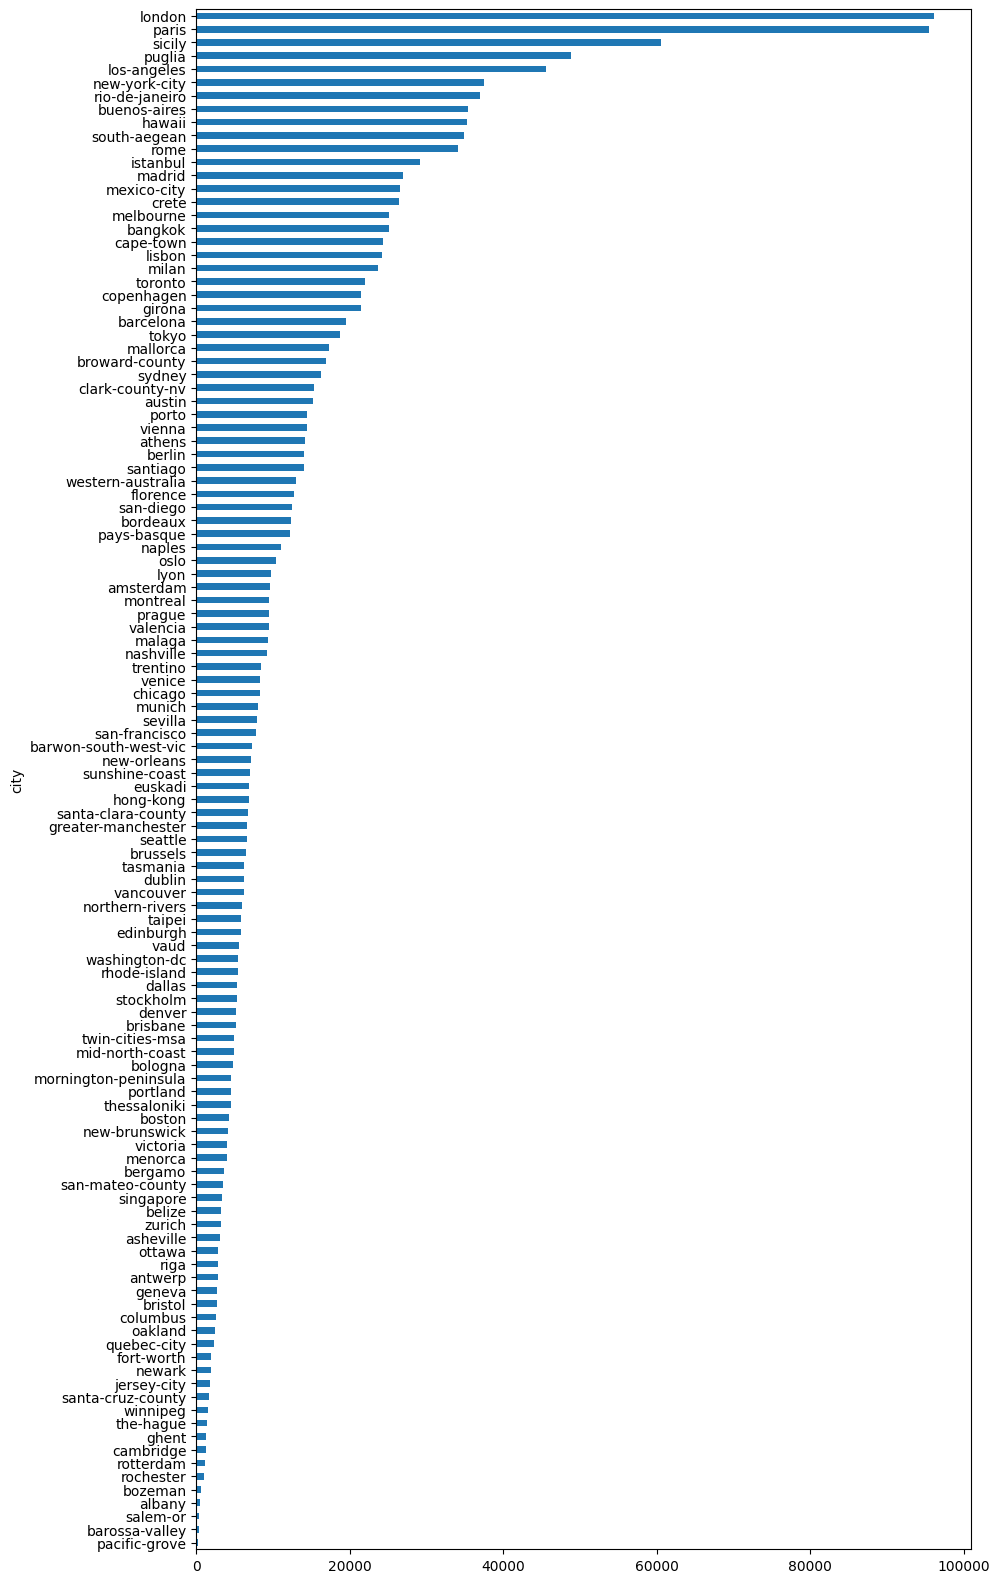

In [18]:
a.city.value_counts(ascending = True).plot(kind = 'barh', figsize = (10,20))

In [19]:
top_cities = list(a.city.value_counts(ascending = True).nlargest(30).index)

In [20]:
a.query('city in @top_cities')['input_file'].unique()

array(['file:///content/airbnb_data/paris/listings.csv.gz',
       'file:///content/airbnb_data/london/listings.csv.gz',
       'file:///content/airbnb_data/sicily/listings.csv.gz',
       'file:///content/airbnb_data/los-angeles/listings.csv.gz',
       'file:///content/airbnb_data/puglia/listings.csv.gz',
       'file:///content/airbnb_data/hawaii/listings.csv.gz',
       'file:///content/airbnb_data/buenos-aires/listings.csv.gz',
       'file:///content/airbnb_data/rome/listings.csv.gz',
       'file:///content/airbnb_data/rio-de-janeiro/listings.csv.gz',
       'file:///content/airbnb_data/new-york-city/listings.csv.gz',
       'file:///content/airbnb_data/south-aegean/listings.csv.gz',
       'file:///content/airbnb_data/crete/listings.csv.gz',
       'file:///content/airbnb_data/melbourne/listings.csv.gz',
       'file:///content/airbnb_data/madrid/listings.csv.gz',
       'file:///content/airbnb_data/mexico-city/listings.csv.gz',
       'file:///content/airbnb_data/cape-town/lis

In [21]:
[x for x in urls_clean if any(y in x for y in top_cities)]

['https://data.insideairbnb.com/united-states/tx/austin/2024-09-13/data/listings.csv.gz',
 'https://data.insideairbnb.com/thailand/central-thailand/bangkok/2024-09-25/data/listings.csv.gz',
 'https://data.insideairbnb.com/spain/catalonia/barcelona/2024-09-06/data/listings.csv.gz',
 'https://data.insideairbnb.com/united-states/fl/broward-county/2024-09-23/data/listings.csv.gz',
 'https://data.insideairbnb.com/argentina/ciudad-autónoma-de-buenos-aires/buenos-aires/2024-11-29/data/listings.csv.gz',
 'https://data.insideairbnb.com/south-africa/wc/cape-town/2024-09-25/data/listings.csv.gz',
 'https://data.insideairbnb.com/united-states/nv/clark-county-nv/2024-09-18/data/listings.csv.gz',
 'https://data.insideairbnb.com/denmark/hovedstaden/copenhagen/2024-09-28/data/listings.csv.gz',
 'https://data.insideairbnb.com/greece/crete/crete/2024-09-26/data/listings.csv.gz',
 'https://data.insideairbnb.com/spain/catalonia/girona/2024-09-29/data/listings.csv.gz',
 'https://data.insideairbnb.com/unite